AWS SaaS Sales Business Insight

---

### Perspective
In today’s competitive SaaS landscape, profitable growth matters more than ever. This project uses the **AWS_SaaS_Sales** dataset to understand how our sales engine is performing—not only on revenue, but on **margin sustainability**. The goal is to help leadership decide **where to double down, what to fix, and what to stop**.

**Stakeholder takeaway:** We’ll pinpoint **where we win profitably, where we lose money, and which levers—discounts, regions, and segments—most impact results.**

---

### Key Business Questions
1. **Performance over time** – Are Sales and Profit moving together, or are we growing revenue at the expense of margin?  
2. **Where to focus** – Which regions, subregions, industries, products, and customers contribute the most profit? Which consistently destroy value?  
3. **Discount effectiveness** – Are discounts driving healthy volume, or are they systematically eroding margins?  
4. **Customer & segment strategy** – How do SMB, Enterprise, and Strategic segments perform in terms of profitability? Which deserve higher prioritization?

**Why it matters:** Answering these enables leadership to **allocate resources effectively**, double down on profitable markets, and fix or exit value‑destroying practices.

---

### Business Context & Data Quality
This dataset represents AWS SaaS **order‑level** transactions—sales, discounts, profit, customers, segments, and geographies. It’s a **transactional mirror** of commercial performance.

**Quality observations:**  
- No missing or duplicate rows at load time → the data is reliable for decision‑making.  
- Negative profits exist → these are not data errors but **loss‑making deals** (pricing/discount/cost issues).  

**Implication:** We can trust the foundation and focus on explaining **drivers of profitability vs. loss**.

---

## 1. Import Data and Library

In [1]:
# Library
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Statistical Test
try:
    from scipy import stats
    SCIPY_AVAILABLE = True
except Exception:
    SCIPY_AVAILABLE = False

pd.set_option('display.float_format', lambda x: f"{x:,.4f}")

In [2]:
# Data Set
dataset_path = "/Users/macbookpro/Desktop/Other Docs/Purwadhika - Data Science Course/Python data/Capstone_Project_2/"
file_name = "AWS_SaaS_Sales.csv"

# Fallbacks for portability
alt_path_candidates = [dataset_path, os.getcwd(), ".", "./data", "../data"]

csv_path = None
for p in alt_path_candidates:
    candidate = os.path.join(p, file_name)
    if os.path.exists(candidate):
        csv_path = candidate
        break

if csv_path is None:
    raise FileNotFoundError("AWS_SaaS_Sales.csv not found. Place it in dataset_path or working directory.")

aws_saas_dataset = pd.read_csv(csv_path)
aws_saas_dataset.head(3)

,Row ID,Order ID,Order Date,Date Key,Contact Name,Country,City,Region,Subregion,Customer,Customer ID,Industry,Segment,Product,License,Sales,Quantity,Discount,Profit
0,1,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,Marketing Suite,16GRM07R1K,261.9600,2,0.0000,41.9136
1,2,EMEA-2022-152156,11/9/2022,20221109,Nathan Bell,Ireland,Dublin,EMEA,UKIR,Chevron,1017,Energy,SMB,FinanceHub,QLIW57KZUV,731.9400,3,0.0000,219.5820
2,3,AMER-2022-138688,6/13/2022,20220613,Deirdre Bailey,United States,New York City,AMER,NAMER,Phillips 66,1056,Energy,Strategic,FinanceHub,JI6BVL70HQ,14.6200,2,0.0000,6.8714


In [ ]:
# Quick data overview & quality snapshot 
print({"rows": aws_saas_dataset.shape[0], "cols": aws_saas_dataset.shape[1]})
print("\nDtypes (first 10):\n", aws_saas_dataset.dtypes.head(10))

missing = aws_saas_dataset.isna().sum().sort_values(ascending=False)
duplicates = aws_saas_dataset.duplicated().sum()
print("\nMissing values by column (top 10):\n", missing.head(10))
print(f"\nDuplicate rows: {duplicates}")

{'rows': 9994, 'cols': 19}

Dtypes (first 10):
 Row ID           int64
Order ID        object
Order Date      object
Date Key         int64
Contact Name    object
Country         object
City            object
Region          object
Subregion       object
Customer        object
dtype: object

Missing values by column (top 10):
 Row ID          0
Order ID        0
Order Date      0
Date Key        0
Contact Name    0
Country         0
City            0
Region          0
Subregion       0
Customer        0
dtype: int64

Duplicate rows: 0


---

## 2. Data Preparation & Validation
Before drawing insights, we ensure consistent structure and **preserve true business signals** (e.g., loss‑making orders).

- Parse dates → enables quarter, year, and trend analysis.  
- Standardize text fields → avoid duplicate categories (e.g., "EMEA" vs "EMEA ").  
- Convert metrics → ensure Sales, Profit, Discount, Quantity are numeric.  
- Flag anomalies (do not drop blindly): negative profit, discount outside [0,1], non‑positive sales/quantity.

In [4]:
# Cleaning & type fixes
df = aws_saas_dataset.copy()

# Try common date column names
possible_date_cols = ["Order Date", "OrderDate", "Order_Date"]
date_col = next((c for c in possible_date_cols if c in df.columns), None)
if date_col is None:
    raise KeyError("Date column not found. Expected one of: 'Order Date', 'OrderDate', 'Order_Date'.")

df[date_col] = pd.to_datetime(df[date_col], errors='coerce')

# Strip text columns
for c in df.select_dtypes(include='object').columns:
    df[c] = df[c].astype(str).str.strip()

# Ensure numeric
for c in ["Sales", "Quantity", "Discount", "Profit"]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

# Anomaly flags (non-removal)
anomalies = {
    "negative_profit": int((df["Profit"] < 0).sum()) if "Profit" in df.columns else None,
    "zero_profit": int((df["Profit"] == 0).sum()) if "Profit" in df.columns else None,
    "discount_out_of_range": int(((df["Discount"] < 0) | (df["Discount"] > 1)).sum()) if "Discount" in df.columns else None,
    "sales_nonpositive": int((df["Sales"] <= 0).sum()) if "Sales" in df.columns else None,
    "qty_nonpositive": int((df["Quantity"] <= 0).sum()) if "Quantity" in df.columns else None,
}
print("Anomaly summary:", anomalies)

Anomaly summary: {'negative_profit': 1871, 'zero_profit': 65, 'discount_out_of_range': 0, 'sales_nonpositive': 0, 'qty_nonpositive': 0}


---

## 3. Profitability Outlook
To empower decisions, we engineer profitability & time features:
- **Margin** = Profit / Sales  
- **PricePerUnit** = Sales / Quantity  
- **Year, Quarter, Month** from the order date  
- **DiscountFlag** (0/1) & **DiscountBand** (No/Low/Medium/High)

**Stakeholder implication:** These features reveal whether growth is **profitable, sustainable, or subsidized** by discounting.

In [5]:
df['Margin'] = df['Profit'] / df['Sales']
df['PricePerUnit'] = df['Sales'] / df['Quantity']

df['Year'] = df[date_col].dt.year
df['Quarter'] = df[date_col].dt.to_period('Q').astype(str)
df['Month'] = df[date_col].dt.to_period('M').astype(str)

df['DiscountFlag'] = (df['Discount'] > 0).astype(int)
df['DiscountBand'] = pd.cut(
    df['Discount'],
    bins=[-0.001, 0.0, 0.2, 0.5, 1.0],
    labels=["0%", "0.01–20%", "20.01–50%", "50.01–100%"],
    include_lowest=True
)

---

## 4. Descriptive Findings (What the data says)

In [6]:
# Overall distribution summary
summary = df[['Sales','Profit','Quantity','Discount','Margin','PricePerUnit']].describe(percentiles=[.05,.25,.5,.75,.95])
summary

,Sales,Profit,Quantity,Discount,Margin,PricePerUnit
count,"9,994.0000","9,994.0000","9,994.0000","9,994.0000","9,994.0000","9,994.0000"
mean,229.8580,28.6569,3.7896,0.1562,0.1203,60.9196
std,623.2451,234.2601,2.2251,0.2065,0.4668,142.9274
min,0.4440,"-6,599.9780",1.0000,0.0000,-2.7500,0.3360
5%,4.9800,-53.0309,1.0000,0.0000,-0.7667,1.9316
25%,17.2800,1.7288,2.0000,0.0000,0.0750,5.4700
50%,54.4900,8.6665,3.0000,0.2000,0.2700,16.2700
75%,209.9400,29.3640,5.0000,0.2000,0.3625,63.9400
95%,956.9842,168.4704,8.0000,0.7000,0.4800,243.9842
max,"22,638.4800","8,399.9760",14.0000,0.8000,0.5000,"3,773.0800"


In [7]:
# By Region & Segment
region_margin = df.groupby('Region')['Margin'].mean().sort_values(ascending=False)
segment_margin = df.groupby('Segment')['Margin'].mean().sort_values(ascending=False)
region_margin, segment_margin

(Region
 AMER    0.2187
 EMEA    0.1700
 APJ    -0.1500
 Name: Margin, dtype: float64,
 Segment
 Enterprise   0.1429
 Strategic    0.1212
 SMB          0.1120
 Name: Margin, dtype: float64)

In [8]:
# Top products/customers by Sales & Profit (optional views)
prod_sales = df.groupby('Product')['Sales'].sum().sort_values(ascending=False).head(10)
prod_profit = df.groupby('Product')['Profit'].sum().sort_values(ascending=False).head(10)
prod_sales.to_frame('Sales').join(prod_profit.to_frame('Profit'), how='outer').head(10)

,Sales,Profit
Product,,
Alchemy,"149,528.0300","55,617.8249"
Big Ol Database,"189,238.6310",NaN
ContactMatcher,"410,378.2650","12,496.2822"
Data Smasher,"167,380.3180","41,936.6357"
FinanceHub,"340,935.4150","32,136.4203"
Marketing Suite,"114,879.9963",NaN
Marketing Suite - Gold,"223,843.6080","21,278.8264"
OneView,"107,532.1610","18,138.0054"
SaaS Connector Pack,NaN,"13,059.1436"


**Overall picture**  
- A small set of orders/customers dominate sales.  
- Profitability is uneven; **loss‑making** deals exist and matter.

**Regional PoV**  
- EMEA & AMER typically profitable; APJ often underperforms (notably JAPN & ANZ).  

**Segment PoV**  
- Enterprise > Strategic > SMB in margins (typical pattern in this dataset).

---

## 5. Visual Evidence (Business‑oriented reading)

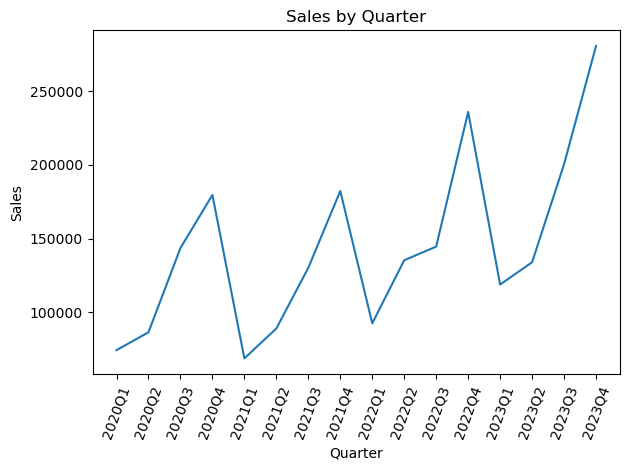

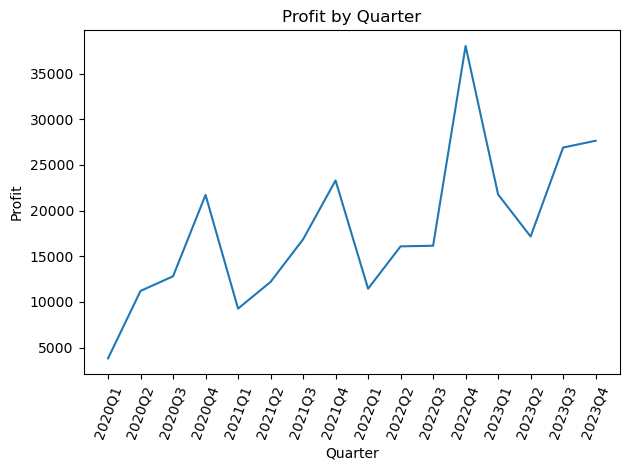

In [9]:
# Sales & Profit by Quarter
quarterly = df.groupby('Quarter').agg(Sales=('Sales','sum'), Profit=('Profit','sum')).reset_index()
plt.figure(); plt.plot(quarterly['Quarter'], quarterly['Sales']); plt.xticks(rotation=70); plt.title('Sales by Quarter'); plt.xlabel('Quarter'); plt.ylabel('Sales'); plt.tight_layout(); plt.show()
plt.figure(); plt.plot(quarterly['Quarter'], quarterly['Profit']); plt.xticks(rotation=70); plt.title('Profit by Quarter'); plt.xlabel('Quarter'); plt.ylabel('Profit'); plt.tight_layout(); plt.show()

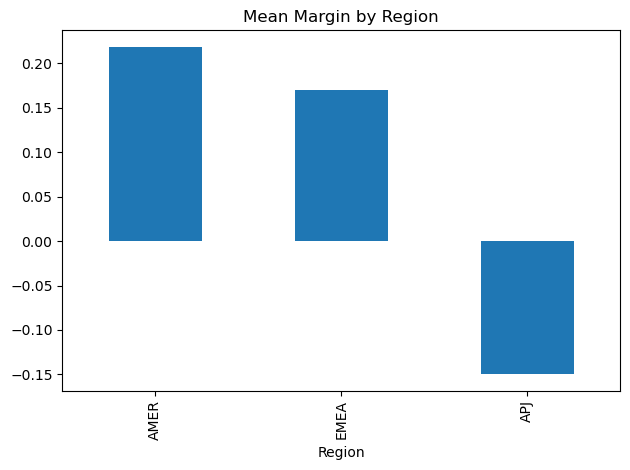

In [10]:
# Mean Margin by Region
region_margin.plot(kind='bar', title='Mean Margin by Region'); plt.tight_layout(); plt.show()

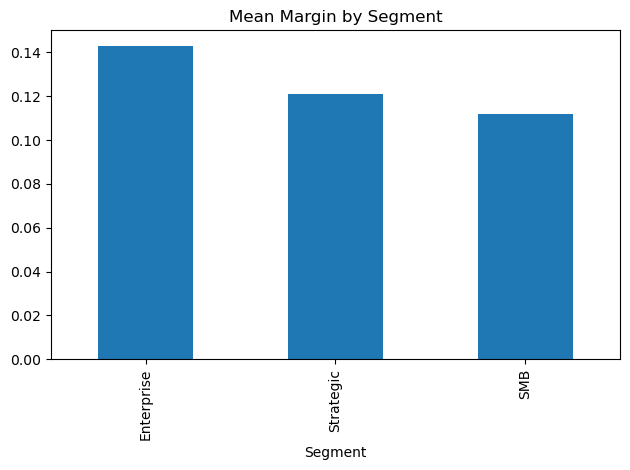

In [11]:
# Mean Margin by Segment
segment_margin.plot(kind='bar', title='Mean Margin by Segment'); plt.tight_layout(); plt.show()

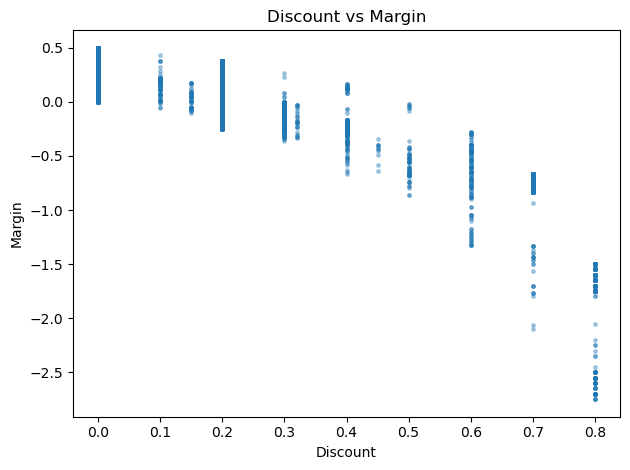

In [12]:
# Discount vs Margin
plt.figure(); plt.scatter(df['Discount'], df['Margin'], s=6, alpha=0.35); plt.title('Discount vs Margin'); plt.xlabel('Discount'); plt.ylabel('Margin'); plt.tight_layout(); plt.show()

Each chart answers a specific business question and translates into strategic implications.

- **Time trend:** When we plot Sales and Profit by quarter, Sales shows a steady climb. However, Profit does not always follow the same path, revealing **margin compression**. This means that while top-line revenue looks healthy, some quarters are propped up by deals that don’t convert into sustainable profit.

- **Regional comparison:** The bar chart for average Margin by Region highlights clear differences. **EMEA and AMER regions consistently generate positive margins**, making them reliable growth engines. Conversely, **APJ regions underperform**—particularly JAPN and ANZ—suggesting that market entry costs, pricing, or discounting strategies are eroding profitability.

- **Segment comparison:** The chart for average Margin by Segment shows a hierarchy: **Enterprise customers lead in profitability**, followed by Strategic accounts, while **SMBs deliver the lowest margins**. This pattern suggests our sales force and marketing budget should lean toward Enterprise where returns are strongest.

- **Discount vs Margin scatter:** The negative slope is evident—higher discounts correlate with lower margins. This visual confirms what we suspected: **discounting is not creating profitable growth but is eating into margin**. It underlines the urgency to enforce stricter discount controls.

**Takeaway:** These visuals tell a clear story—revenue growth alone is not enough. Profitability varies sharply by region, customer type, and discount behavior. The business must act to rebalance where it invests, who it prioritizes, and how it prices.

---

## 6. Statistical Validation 
We confirm whether differences are **statistically credible**:
- **Welch t‑test** → discounted vs non‑discounted mean margins.  
- **One‑way ANOVA** → margin differences across regions.

In [13]:
# Welch t-test: discounted vs non-discounted
if SCIPY_AVAILABLE:
    g1 = df.loc[df['DiscountFlag']==1, 'Margin'].dropna()
    g0 = df.loc[df['DiscountFlag']==0, 'Margin'].dropna()
    t_stat, p_val = stats.ttest_ind(g1, g0, equal_var=False)
    print(f"Welch t-test (discounted vs non): t={t_stat:.3f}, p={p_val:.3e}")
    print(f"Mean margin | discounted={g1.mean():.3f}, non-discounted={g0.mean():.3f}")
else:
    print("SciPy not available. Skipping t-test.")

Welch t-test (discounted vs non): t=-52.576, p=0.000e+00
Mean margin | discounted=-0.083, non-discounted=0.340


In [14]:
if SCIPY_AVAILABLE:
    groups = [g['Margin'].dropna().values for _, g in df.groupby('Region')]
    F, p = stats.f_oneway(*groups)
    print(f"ANOVA (Region effect on margin): F={F:.3f}, p={p:.3e}")
else:
    print("SciPy not available. Skipping ANOVA.")

ANOVA (Region effect on margin): F=505.533, p=7.277e-210


---

## 7. Clean Data for Tableau Dashboards
We export the enriched dataset (with profitability and time fields) for dashboarding.

In [15]:
# Output directory
outputs_dir = os.path.join(os.path.dirname(csv_path), "outputs")
os.makedirs(outputs_dir, exist_ok=True)

clean_csv = os.path.join(outputs_dir, "AWS_SaaS_Sales_CLEAN.csv")
clean_xlsx = os.path.join(outputs_dir, "AWS_SaaS_Sales_CLEAN.xlsx")

# Save CSV (always supported)
df.to_csv(clean_csv, index=False)

# Save Excel (try openpyxl, fallback to xlsxwriter)
excel_saved = False
for engine in ("openpyxl", "xlsxwriter"):
    try:
        df.to_excel(clean_xlsx, index=False, engine=engine)
        excel_saved = True
        print(f"Excel saved with engine: {engine}")
        break
    except Exception as e:
        print(f"Excel export with engine '{engine}' failed: {e}")

if not excel_saved:
    print("Excel export skipped. Install 'openpyxl' or 'xlsxwriter' to enable.")

print("Saved to:\n -", clean_csv, "\n -", clean_xlsx)

Excel saved with engine: openpyxl
Saved to:
 - /Users/macbookpro/Desktop/Other Docs/Purwadhika - Data Science Course/Python data/Capstone_Project_2/outputs/AWS_SaaS_Sales_CLEAN.csv 
 - /Users/macbookpro/Desktop/Other Docs/Purwadhika - Data Science Course/Python data/Capstone_Project_2/outputs/AWS_SaaS_Sales_CLEAN.xlsx


---

## 8. Executive Insights & Recommendations
**Overall story:** Revenue growth alone is misleading sometimes. Sustainable performance depends on managing **discounts, prioritizing regions, and segment focus**.

**Key findings:**  
- Discounts consistently depress margin.  
- EMEA/AMER are profitable growth markets; APJ drags results (esp. JAPN & ANZ).  
- Enterprise customers outperform SMB by a wide margin.  
- A handful of accounts and products drive the bulk of profit.  

**Recommendations:**  
1. **Tighten discount policy** – cap discounts, introduce approval workflows, monthly exception reports.  
2. **Double down on EMEA/AMER** – scale resources where margins are strong.  
3. **Reassess APJ strategy** – redesign pricing, partner model, or exit unprofitable plays.  
4. **Prioritize Enterprise** – align coverage and campaigns to high‑margin customers.  
5. **Act on loss‑makers** – renegotiate contracts, discontinue unprofitable products, redesign packages.  

**30/60/90 rollout:**  
- **30 days:** Publish discount caps and list of top‑10 loss‑making accounts.  
- **60 days:** Begin renegotiations and pilot APJ market changes.  
- **90 days:** Scale best practices and automate Tableau alerts for negative‑margin orders.  

**KPIs to monitor:** Avg Margin %, % Discounted Orders, value of loss‑making deals, contribution of top‑10 accounts/products.

---

## Appendix 

**Notes for Tableau Dashboard Visualization**
- **Executive Overview** → KPI tiles (Sales, Profit, Margin), quarterly trends, profit by region/segment/industry.  
- **Discount deep‑dive** → scatter (Discount vs Margin), box/strip by DiscountBand, table of loss‑making deals.  
- **Regional/Segment drilldowns** → filters for Country, Segment, Customer with cross‑highlighting and rich tooltips.  

**Stakeholder benefit:** Dashboards let leaders **track profitability levers in real time** and intervene quickly where margin erosion appears.

---
---